## 01 Exploratory Data Analysis

### Environment

##### Install from requirements.txt

In [ ]:
# Designed for Python 3.11.9
# !python -m pip install -r requirements.txt

##### Install each requirement in notebook

In [ ]:
# Alternative for running in Colab etc
!python -m pip install --upgrade pip
!pip install numpy==1.24.1
!pip install pmdarima==2.0.4
!python -m pip install ibis-framework[duckdb]==9.5.0
!pip install pandas==2.2.3
!pip install matplotlib==3.9.2
!pip install skforecast==0.14.0

  Using cached ibis_framework-9.5.0-py3-none-any.whl.metadata (17 kB)
  Using cached atpublic-5.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached parsy-2.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached sqlglot-25.20.2-py3-none-any.whl.metadata (19 kB)
  Using cached toolz-0.12.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached duckdb-1.1.3-cp311-cp311-win_amd64.whl.metadata (781 bytes)
  Using cached pyarrow-17.0.0-cp311-cp311-win_amd64.whl.metadata (3.4 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached ibis_framework-9.5.0-py3-none-any.whl (2.0 MB)
Using cached atpublic-5.0-py3-none-any.whl (5.2 kB)
Using cached duckdb-1.1.3-cp311-cp311-win_amd64.whl (11.0 MB)
Using cached parsy-2.1-py3-none-any.whl (9.1 kB)
Using cached pyarrow-17.0.0-cp311-cp311-win_

### Import Data

Key tools:
- [Ibis](https://ibis-project.org/) on a [DuckDB](https://duckdb.org/) backend with transformations to [Pandas](https://pandas.pydata.org/docs/index.html) for certain operations.
- Some excessively-verbose functions spun out to a data prep module 

In [ ]:
import pandas as pd
import methods.prep as prep
import ibis

##### Load Individual Datasets

In [4]:
con = ibis.connect("duckdb://")
data_path = 'data_staged/'

In [5]:
# Load FRED datasets
fred_dataset_names = [
    'consumer-sentiment',
    'cpi',
    'hourly-wage',
    'house-median-price',
    'house-starts',
    'unemployment',
]

fred_datasets = {}

print('\nFRED Datasets (single-variable time series)')
for name in fred_dataset_names:
    fred_datasets[name] = ibis.read_csv(
        data_path + name + '.csv',
        dateformat='%m/%d/%Y')
    print(name + ': ' + str(fred_datasets[name].to_pandas().shape))


FRED Datasets (single-variable time series)
consumer-sentiment: (864, 2)
cpi: (682, 2)
hourly-wage: (224, 2)
house-median-price: (247, 2)
house-starts: (790, 2)
unemployment: (922, 2)


In [6]:
# Load investing.com datasets

inv_dataset_names = [
    'copper', 
    'corn', 
    'gold',
    'lumber',
    'natural-gas',
    'oil-wti',
    'r2000', 
    'soy',
    'sp500',
    'vix-volatility'
]

traded_commodities = [
    'copper'
]

inv_datasets = {}

print('Investing.com Datasets (standard prices and volume time series)')
for name in inv_dataset_names:
    inv_datasets[name] = ibis.read_csv(
        data_path + name + '.csv',
        dateformat='%m/%d/%Y')
    print(name + ': ' + str(inv_datasets[name].to_pandas().shape))


    

Investing.com Datasets (standard prices and volume time series)
copper: (4868, 7)
corn: (4819, 7)
gold: (4820, 7)
lumber: (4829, 7)
natural-gas: (4897, 7)
oil-wti: (4917, 7)
r2000: (5000, 7)
soy: (4939, 7)
sp500: (4769, 7)
vix-volatility: (4794, 7)


##### Initial Preprocessing - Individual Datasets

In [7]:
for key in inv_datasets.keys():
    #Drop unnecessary columns
    inv_datasets[key] = inv_datasets[key].drop('Vol.','Change %')

    #Add trading day flag to traded columns
    if key in traded_commodities:
        inv_datasets[key] = inv_datasets[key].mutate(
            TRADING_DAY = True
        )

    #Convert column names to ALL CAPS
    inv_datasets[key] = inv_datasets[key].rename('ALL_CAPS')

    # Convert PRICE, OPEN, HIGH, and LOW to float64s if they are strings
    if inv_datasets[key]['PRICE'].type().is_string():
        inv_datasets[key] = inv_datasets[key].mutate(
            PRICE = inv_datasets[key]['PRICE'].replace(',','').cast('float64'))    

    if inv_datasets[key]['OPEN'].type().is_string():
        inv_datasets[key] = inv_datasets[key].mutate(
            OPEN = inv_datasets[key]['OPEN'].replace(',','').cast('float64'))   

    if inv_datasets[key]['HIGH'].type().is_string():
        inv_datasets[key] = inv_datasets[key].mutate(
            HIGH = inv_datasets[key]['HIGH'].replace(',','').cast('float64'))  

    if inv_datasets[key]['LOW'].type().is_string():
        inv_datasets[key] = inv_datasets[key].mutate(
            LOW = inv_datasets[key]['LOW'].replace(',','').cast('float64'))   

    # Add prefixes to each column based on the name of the dataset
    names_map = {
        f"{key}_{col}" : col 
            for col in inv_datasets[key].columns
            if col != 'DATE'}
    inv_datasets[key] = inv_datasets[key].rename(names_map)

for k,v in inv_datasets.items():
    print(v.head())

r0 := DatabaseTable: ibis_read_csv_6skpj23wd5bfrd6yuhxnsbs3ti
  Date     date
  Price    float64
  Open     float64
  High     float64
  Low      float64
  Vol.     string
  Change % string

r1 := DropColumns[r0]
  columns_to_drop:
    frozenset({'Vol.', 'Change %'})
  schema:
    Date  date
    Price float64
    Open  float64
    High  float64
    Low   float64

r2 := Project[r1]
  Date:        r1.Date
  Price:       r1.Price
  Open:        r1.Open
  High:        r1.High
  Low:         r1.Low
  TRADING_DAY: True

r3 := Project[r2]
  DATE:        r2.Date
  PRICE:       r2.Price
  OPEN:        r2.Open
  HIGH:        r2.High
  LOW:         r2.Low
  TRADING_DAY: r2.TRADING_DAY

r4 := Project[r3]
  DATE:               r3.DATE
  copper_PRICE:       r3.PRICE
  copper_OPEN:        r3.OPEN
  copper_HIGH:        r3.HIGH
  copper_LOW:         r3.LOW
  copper_TRADING_DAY: r3.TRADING_DAY

Limit[r4, n=5]
r0 := DatabaseTable: ibis_read_csv_6lul2idmbbgxjgfsohxnatqna4
  Date     date
  Price    float6

In [8]:
# Fix column names in FRED data and drop unused rows
for key in fred_datasets.keys():
    #Rename second column (data) to name of dataset
    old_col_name = fred_datasets[key].columns[1]
    new_col_name = key
    fred_datasets[key] = fred_datasets[key].rename({new_col_name: old_col_name})

    #Convert timestamps to dates
    fred_datasets[key] = fred_datasets[key].mutate(
        DATE = fred_datasets[key]['DATE'].cast('date'))

    #Convert to snake-case
    fred_datasets[key] = fred_datasets[key].rename('ALL_CAPS')

    #Drop unused rows 
    fred_datasets[key] = fred_datasets[key].filter(fred_datasets[key].DATE.year() > 2005)

# Convert string to float64 in consumer sentiment data   
fred_datasets['consumer-sentiment'] = fred_datasets['consumer-sentiment'].mutate(
    CONSUMER_SENTIMENT  = fred_datasets['consumer-sentiment']['CONSUMER_SENTIMENT'].replace(',','').cast('float64'))

for k,v in fred_datasets.items():
    #print(k)
    print(v.head())

r0 := DatabaseTable: ibis_read_csv_zxorxyelebdelmnu3ceo2ndcke
  DATE    timestamp(6)
  UMCSENT string

r1 := Project[r0]
  DATE:               r0.DATE
  consumer-sentiment: r0.UMCSENT

r2 := Project[r1]
  DATE:               Cast(r1.DATE, to=date)
  consumer-sentiment: r1['consumer-sentiment']

r3 := Project[r2]
  DATE:               r2.DATE
  CONSUMER_SENTIMENT: r2['consumer-sentiment']

r4 := Filter[r3]
  ExtractYear(r3.DATE) > 2005

r5 := Project[r4]
  DATE:               r4.DATE
  CONSUMER_SENTIMENT: Cast(StringReplace(r4.CONSUMER_SENTIMENT, pattern=',', replacement=''), to=float64)

Limit[r5, n=5]
r0 := DatabaseTable: ibis_read_csv_ulinkj76kveijj3pp7hwg7z4fu
  DATE                 timestamp(6)
  CORESTICKM159SFRBATL float64

r1 := Project[r0]
  DATE: r0.DATE
  cpi:  r0.CORESTICKM159SFRBATL

r2 := Project[r1]
  DATE: Cast(r1.DATE, to=date)
  cpi:  r1.cpi

r3 := Project[r2]
  DATE: r2.DATE
  CPI:  r2.cpi

r4 := Filter[r3]
  ExtractYear(r3.DATE) > 2005

Limit[r4, n=5]
r0 := DatabaseT

##### Merge Datasets

In [9]:
# Merge all tables from the Investing.com dataset
inv_data = prep.merge_tables(
    inv_datasets, 
    join_key = 'DATE',
    join_type = 'outer')

# Merge all tables from the FRED dataset together
fred_data = prep.merge_tables(
    fred_datasets, 
    join_key = 'DATE', 
    join_type = 'outer')

# Bring dates from inv table into FRED so values can be imputed
fred_data = prep.merge_tables(
    tables_to_merge={
        'fred' : fred_data,
        'inv' : inv_data.select('DATE')
    },
    join_key = 'DATE',
    join_type = 'outer'
)

# Run the forward-fill imputation - fred data
fred_data = prep.impute_forward_fill(
    data = fred_data,
    sort_by = 'DATE')

# Filter out early nulls from FRED
fred_data = fred_data.filter(fred_data.DATE.year() > 2006)

# Run the forward-fill imputation - investing.com data
# TODO decide whether to keep this
inv_data = prep.impute_forward_fill(
    data = inv_data,
    sort_by = 'DATE')

# Finally, merge the investing.com and FRED data
# Using an inner join to exclude any days which aren't trading days
data = prep.merge_tables(
    {
        'inv' : inv_data, 
        'fred' : fred_data,
    },
    join_key = 'DATE',
    join_type='inner')

# TODO For TRADING_DAY columns,  fill in NaNs with FALSE 


In [10]:
data.to_pandas().shape

(5014, 48)

In [11]:
data.to_pandas().isna().sum()

DATE                      0
copper_PRICE              0
copper_OPEN               0
copper_HIGH               0
copper_LOW                0
copper_TRADING_DAY      419
corn_PRICE                0
corn_OPEN                 0
corn_HIGH                 0
corn_LOW                  0
gold_PRICE                0
gold_OPEN                 0
gold_HIGH                 0
gold_LOW                  0
lumber_PRICE              0
lumber_OPEN               0
lumber_HIGH               0
lumber_LOW                0
natural-gas_PRICE         0
natural-gas_OPEN          0
natural-gas_HIGH          0
natural-gas_LOW           0
oil-wti_PRICE             0
oil-wti_OPEN              0
oil-wti_HIGH              0
oil-wti_LOW               0
r2000_PRICE               0
r2000_OPEN                0
r2000_HIGH                0
r2000_LOW                 0
soy_PRICE                 0
soy_OPEN                  0
soy_HIGH                  0
soy_LOW                   0
sp500_PRICE               0
sp500_OPEN          

##### Data Interpretability & Availability Corrections

In [ ]:
# TODO Add REAL price columns by controlling for time-lagged CPI 
# (divide all prices by relative CPI, indexed to base year)
# Applies to all commodities and equities indexes (ex VIX)
# as well as hourly wages and median house prices

In [ ]:
# TODO Add a US_Housing_Starts_Per_Capita column 
# to provide a clearer economic health indicator

In [ ]:
# TODO Offset macroeconomic indicators to align with when they're reported/available 
# or simplify by lagging all of them 3 months?

##### Feature Engineering for Forecasting

In [ ]:
# TODO Add LAG columns - ~3 month, ~1 year, ~3 years?

In [ ]:
# TODO Add XMA 10-day, 30-day, and 90-day columns to help with technical analysis?

In [ ]:
# TODO Add RATIO columns looking at the relative prices of pairs of commodities?

### Dev-Holdout Data Split 

Starting each period with a crisis!

In [ ]:
training_end_year = 2019

# Split the data into model development (2007 to 2019) 
dev_data = data.filter(data.DATE.year() >= 2007).filter(data.DATE.year() <= training_end_year)

# and final holdout (2020 to late 2024)
holdout_data = data.filter(data.DATE.year() > training_end_year)

### Feature Correlations

Not especially useful since this is time-series data, but a quick look doesn't hurt.  Mostly 

In [13]:
import numpy as np

# TODO switch these to look at only economic indicators and 
# REAL prices, wages, and only closing prices

dev_data.to_pandas().select_dtypes(include=np.number).corr()

,copper_PRICE,copper_OPEN,copper_HIGH,copper_LOW,corn_PRICE,corn_OPEN,corn_HIGH,corn_LOW,gold_PRICE,gold_OPEN,...,vix-volatility_PRICE,vix-volatility_OPEN,vix-volatility_HIGH,vix-volatility_LOW,CONSUMER_SENTIMENT,CPI,HOURLY_WAGE,HOUSE_MEDIAN_PRICE,HOUSE_STARTS,UNEMPLOYMENT
copper_PRICE,1.000000,0.997257,0.998713,0.998835,0.692266,0.690999,0.690815,0.692359,0.374209,0.373351,...,-0.233391,-0.237664,-0.241815,-0.232748,-0.331067,-0.443000,-0.339484,-0.397898,-0.292741,0.391589
copper_OPEN,0.997257,1.000000,0.998638,0.998416,0.692068,0.691813,0.691052,0.692464,0.374381,0.374609,...,-0.228496,-0.234940,-0.237001,-0.228929,-0.331325,-0.441895,-0.339262,-0.397731,-0.292298,0.390905
copper_HIGH,0.998713,0.998638,1.000000,0.997972,0.694597,0.693938,0.693669,0.694664,0.367145,0.366850,...,-0.216651,-0.222165,-0.225011,-0.216697,-0.342540,-0.442653,-0.350980,-0.409768,-0.300692,0.397873
copper_LOW,0.998835,0.998416,0.997972,1.000000,0.689301,0.688329,0.687727,0.689745,0.381239,0.380822,...,-0.246351,-0.251313,-0.254950,-0.245830,-0.319840,-0.441695,-0.327269,-0.385203,-0.283476,0.383538
corn_PRICE,0.692266,0.692068,0.694597,0.689301,1.000000,0.998035,0.999071,0.999130,0.545805,0.545707,...,0.050374,0.049430,0.037576,0.059451,-0.530142,-0.214091,-0.355571,-0.482184,-0.466660,0.498991
corn_OPEN,0.690999,0.691813,0.693938,0.688329,0.998035,1.000000,0.999168,0.999122,0.546068,0.546431,...,0.052173,0.049940,0.039131,0.060603,-0.529402,-0.211661,-0.354556,-0.481270,-0.465209,0.497796
corn_HIGH,0.690815,0.691052,0.693669,0.687727,0.999071,0.999168,1.000000,0.998854,0.539743,0.539821,...,0.059436,0.057687,0.046428,0.068150,-0.537365,-0.212997,-0.362623,-0.489423,-0.471217,0.502585
corn_LOW,0.692359,0.692464,0.694664,0.689745,0.999130,0.999122,0.998854,1.000000,0.552757,0.552826,...,0.043621,0.042128,0.030686,0.052430,-0.522861,-0.213279,-0.347708,-0.474473,-0.461451,0.494917
gold_PRICE,0.374209,0.374381,0.367145,0.381239,0.545805,0.546068,0.539743,0.552757,1.000000,0.998897,...,-0.248607,-0.248132,-0.246981,-0.248839,0.027695,-0.337755,0.410514,0.144073,-0.217653,0.246867
gold_OPEN,0.373351,0.374609,0.366850,0.380822,0.545707,0.546431,0.539821,0.552826,0.998897,1.000000,...,-0.248124,-0.247740,-0.246439,-0.248281,0.027487,-0.337019,0.410491,0.144342,-0.217161,0.246458


**Copper vs other commodities** - we see a mix of very tight positive correlations, in some cases almost perfectly linear.  Some positive correlation is to be expected since we haven't controlled for inflation yet, but inflation wasn't all that high during the dev period.  However, we also see surprisingly loose correlations in some cases, including separate price spikes.  There's some curious multimodality in both price distributions and price correlations.

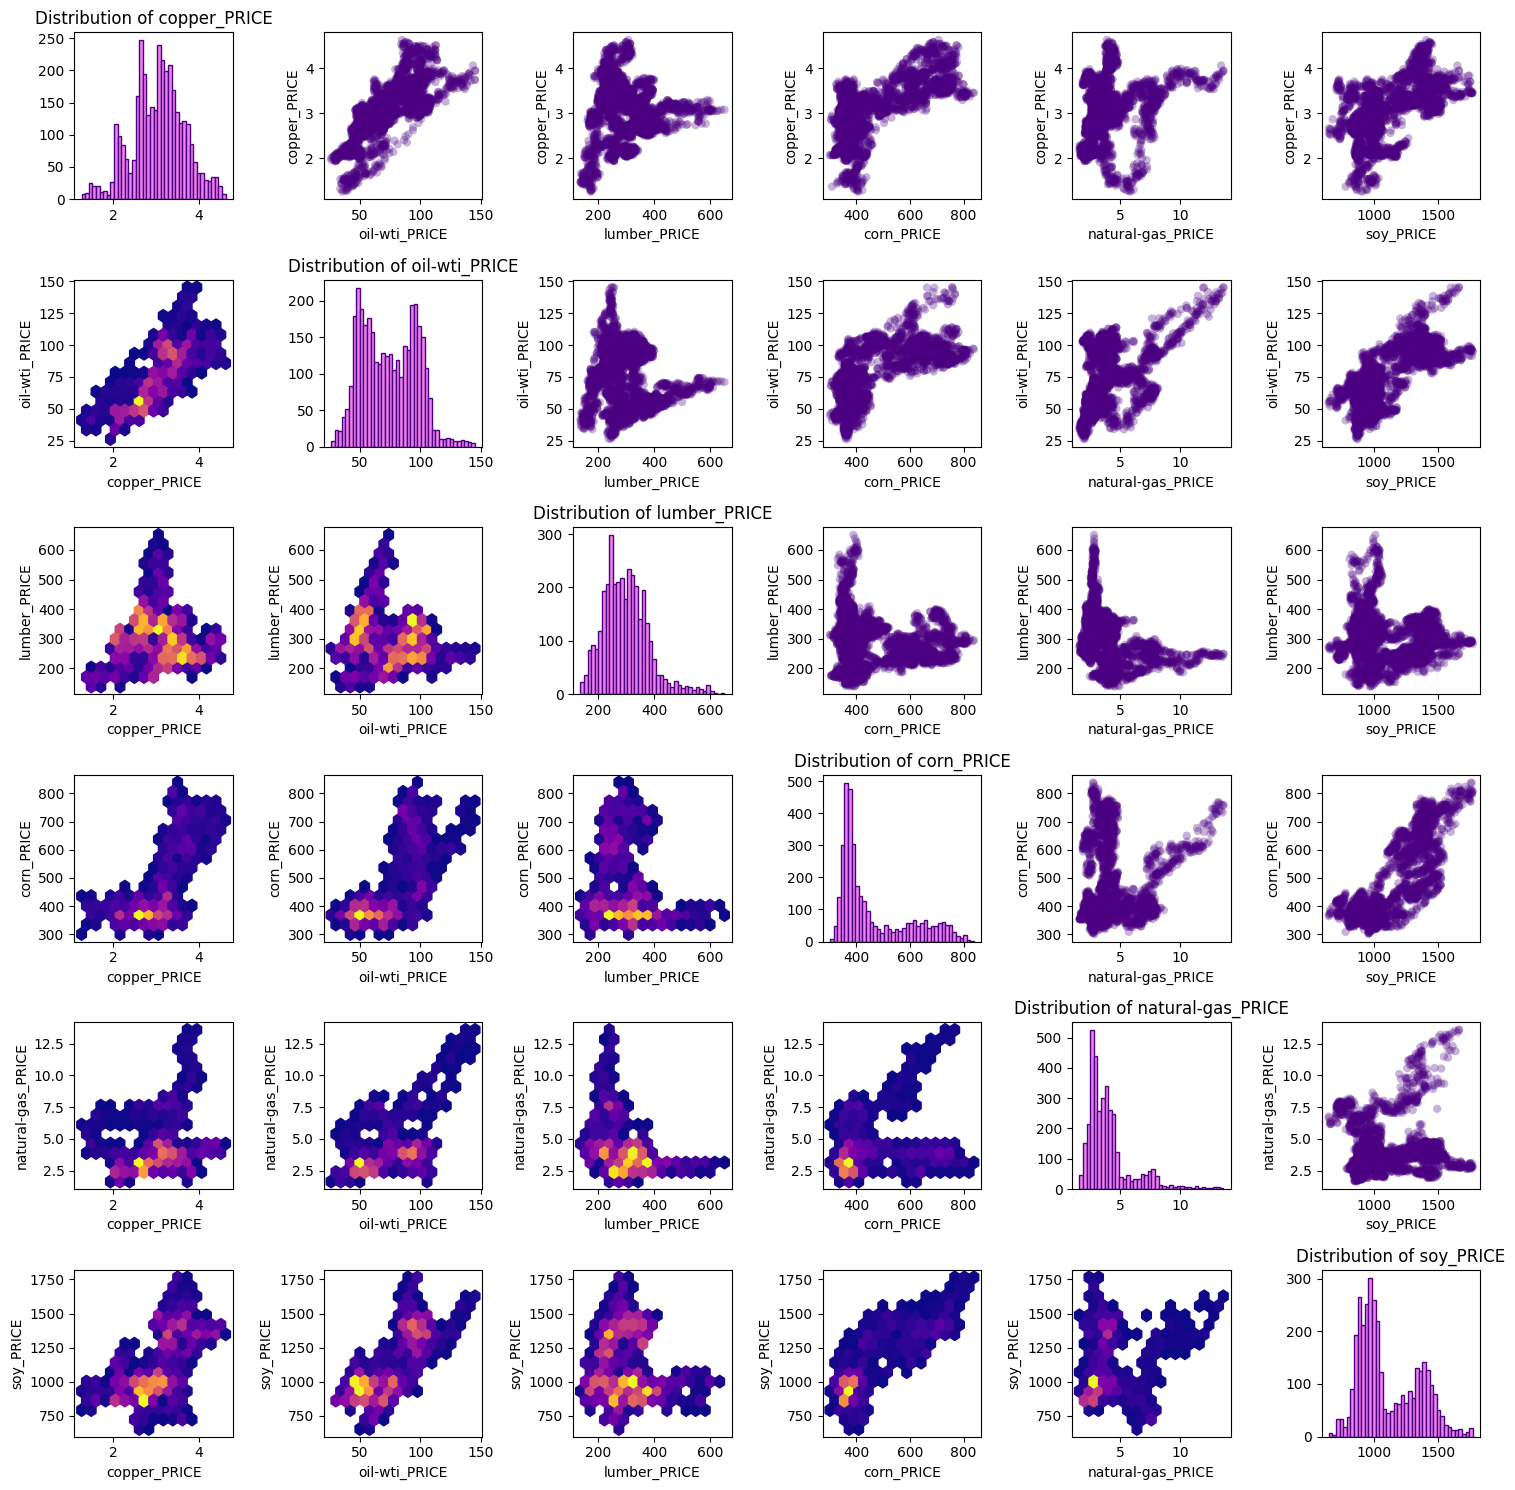

In [14]:
# TODO switch these to REAL prices

import methods.vis as vis
vis.plot_feature_correlation_matrix(
    dev_data.select(
        'copper_PRICE',
        'oil-wti_PRICE',
        'lumber_PRICE',
        'corn_PRICE',
        'natural-gas_PRICE',
        'soy_PRICE',
    ).to_pandas())

**Copper vs economic indicators** - Also shows a mix of straightfoward linear correlation and curious drift and multimodality.

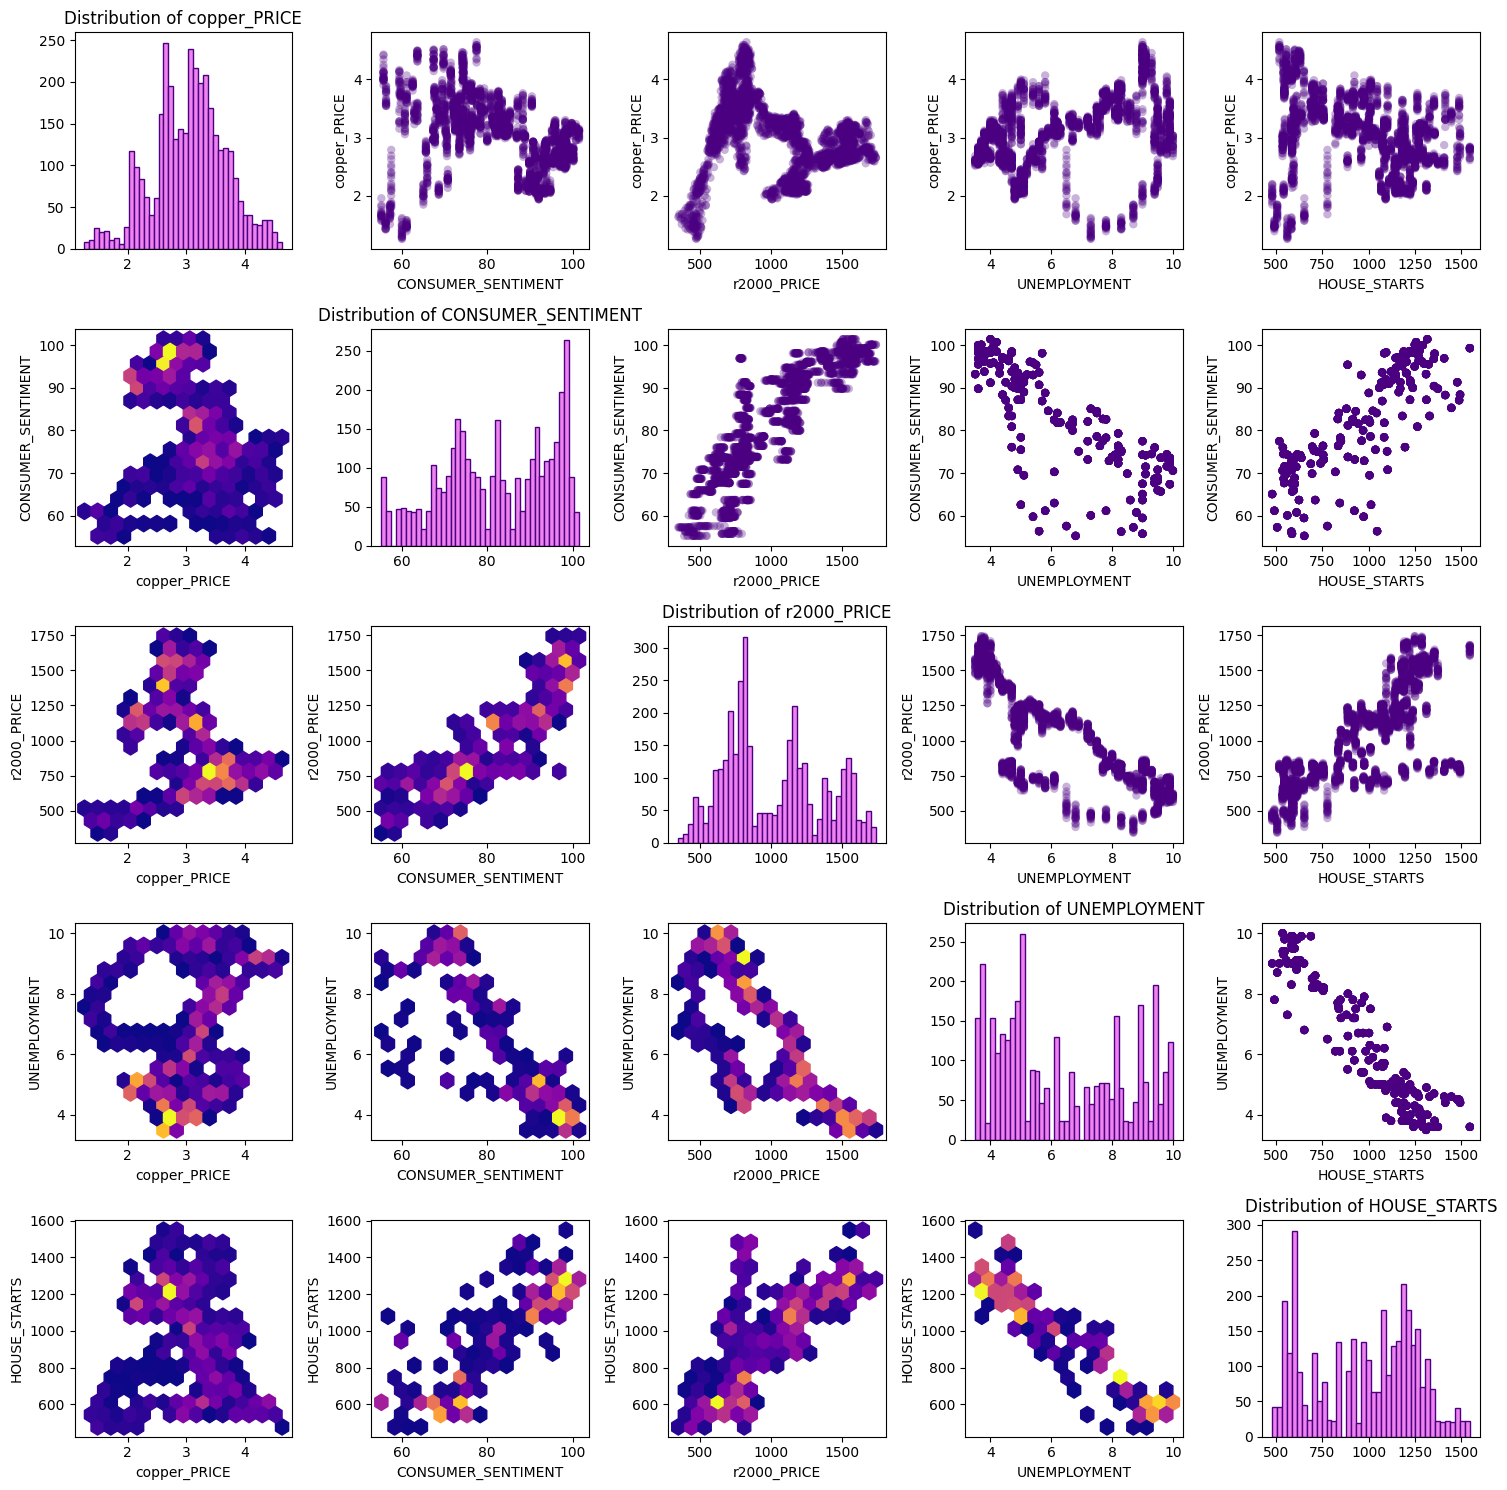

In [15]:
# TODO Switch to REAL prices

vis.plot_feature_correlation_matrix(
    dev_data.select(
        'copper_PRICE',
        'CONSUMER_SENTIMENT',
        'r2000_PRICE',
        'UNEMPLOYMENT',
        'HOUSE_STARTS'
    ).to_pandas())

### Linear Plots & Preliminary Stationarity Analysis

For forecasting, features should be stationary, meaning that no significant trends or seasonal patterns should be present in the data.  The mean and variance should be consistent throughout the time period.

Key tools:
- [skforecast](https://skforecast.org/)
- [pmdarima](https://github.com/alkaline-ml/pmdarima) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import methods.vis as vis
import skforecast
import pmdarima

These are clearly not stationary.  The trends are enormous, and while seasonality is difficult to detect at this level, it's almost certainly present.

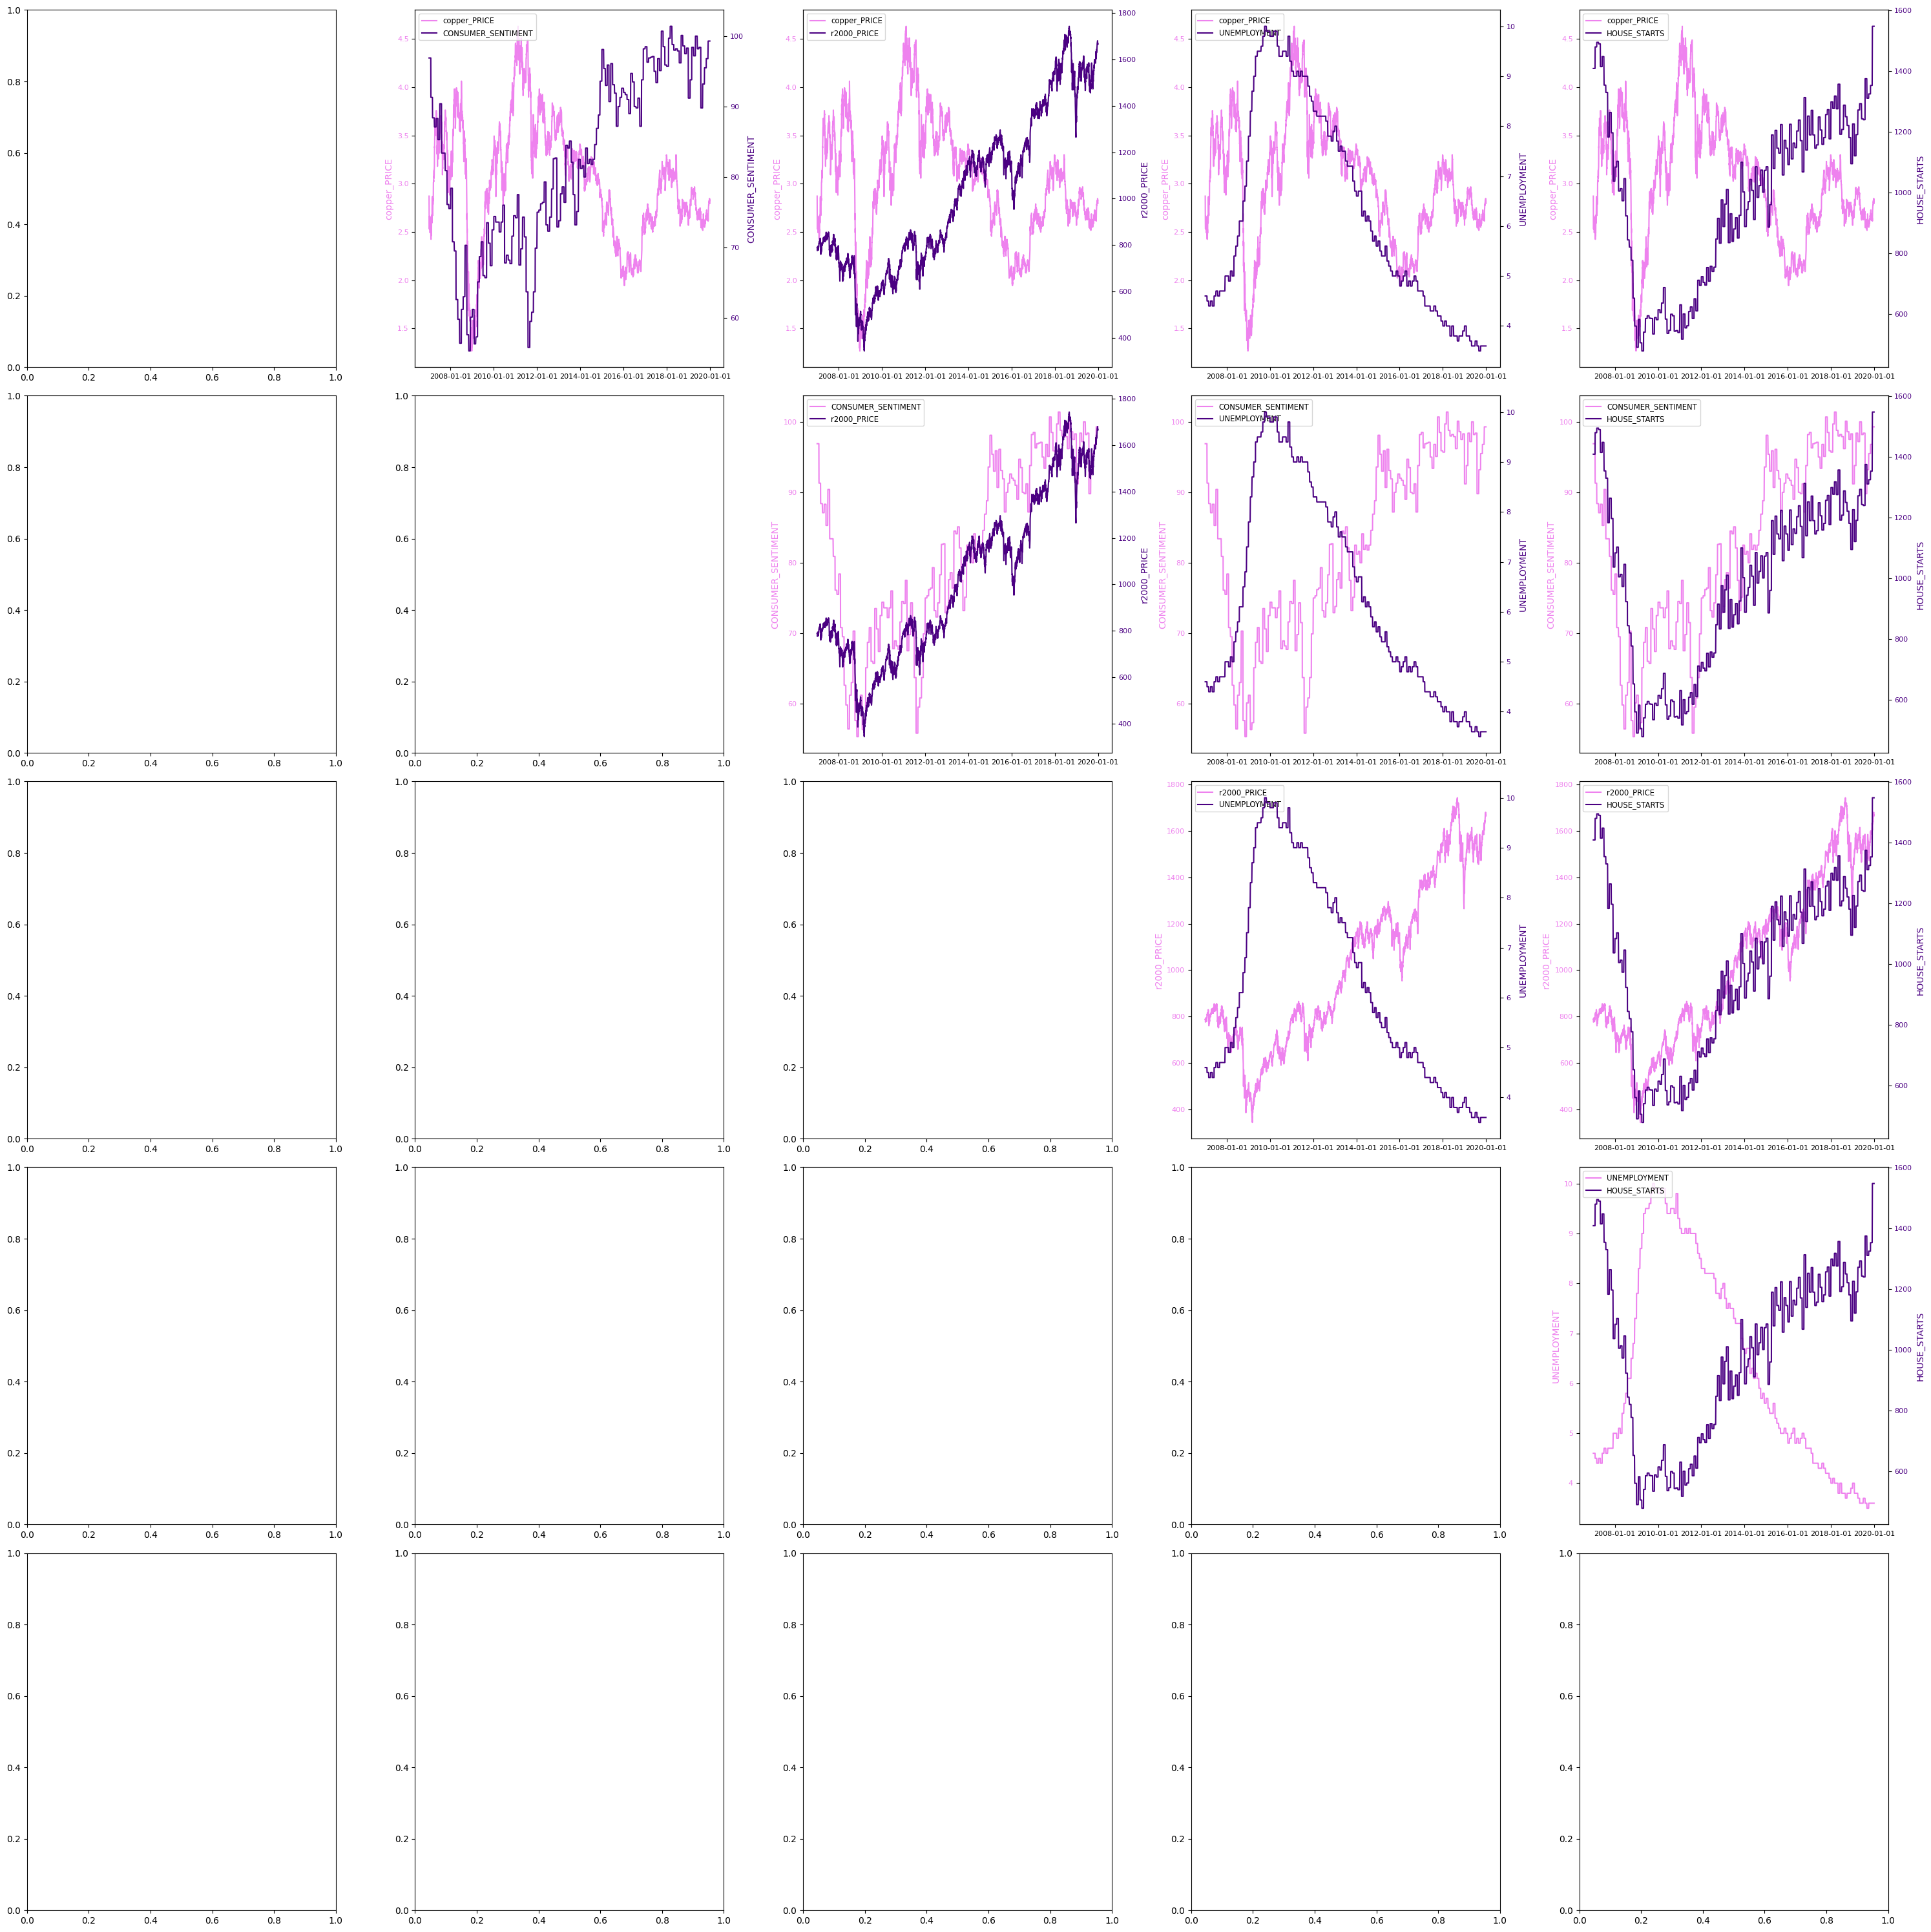

In [30]:
# import importlib
# importlib.reload(vis)
column_list = [
    'DATE',
    'copper_PRICE',
    'CONSUMER_SENTIMENT',
    'r2000_PRICE',
    'UNEMPLOYMENT',
    'HOUSE_STARTS'
]
df = dev_data.select(column_list).to_pandas()
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')
fig, axes = vis.plot_pairwise_time_series_matrix(df)

Many of these look pretty good at first differencing, but some definitely need to be differenced at least one more time.

In [ ]:
# TODO Develop visualization with 5 columns of time series charts 
# (original data, diff1, diff2, diff3, diff4)
# with one row of charts for each series 

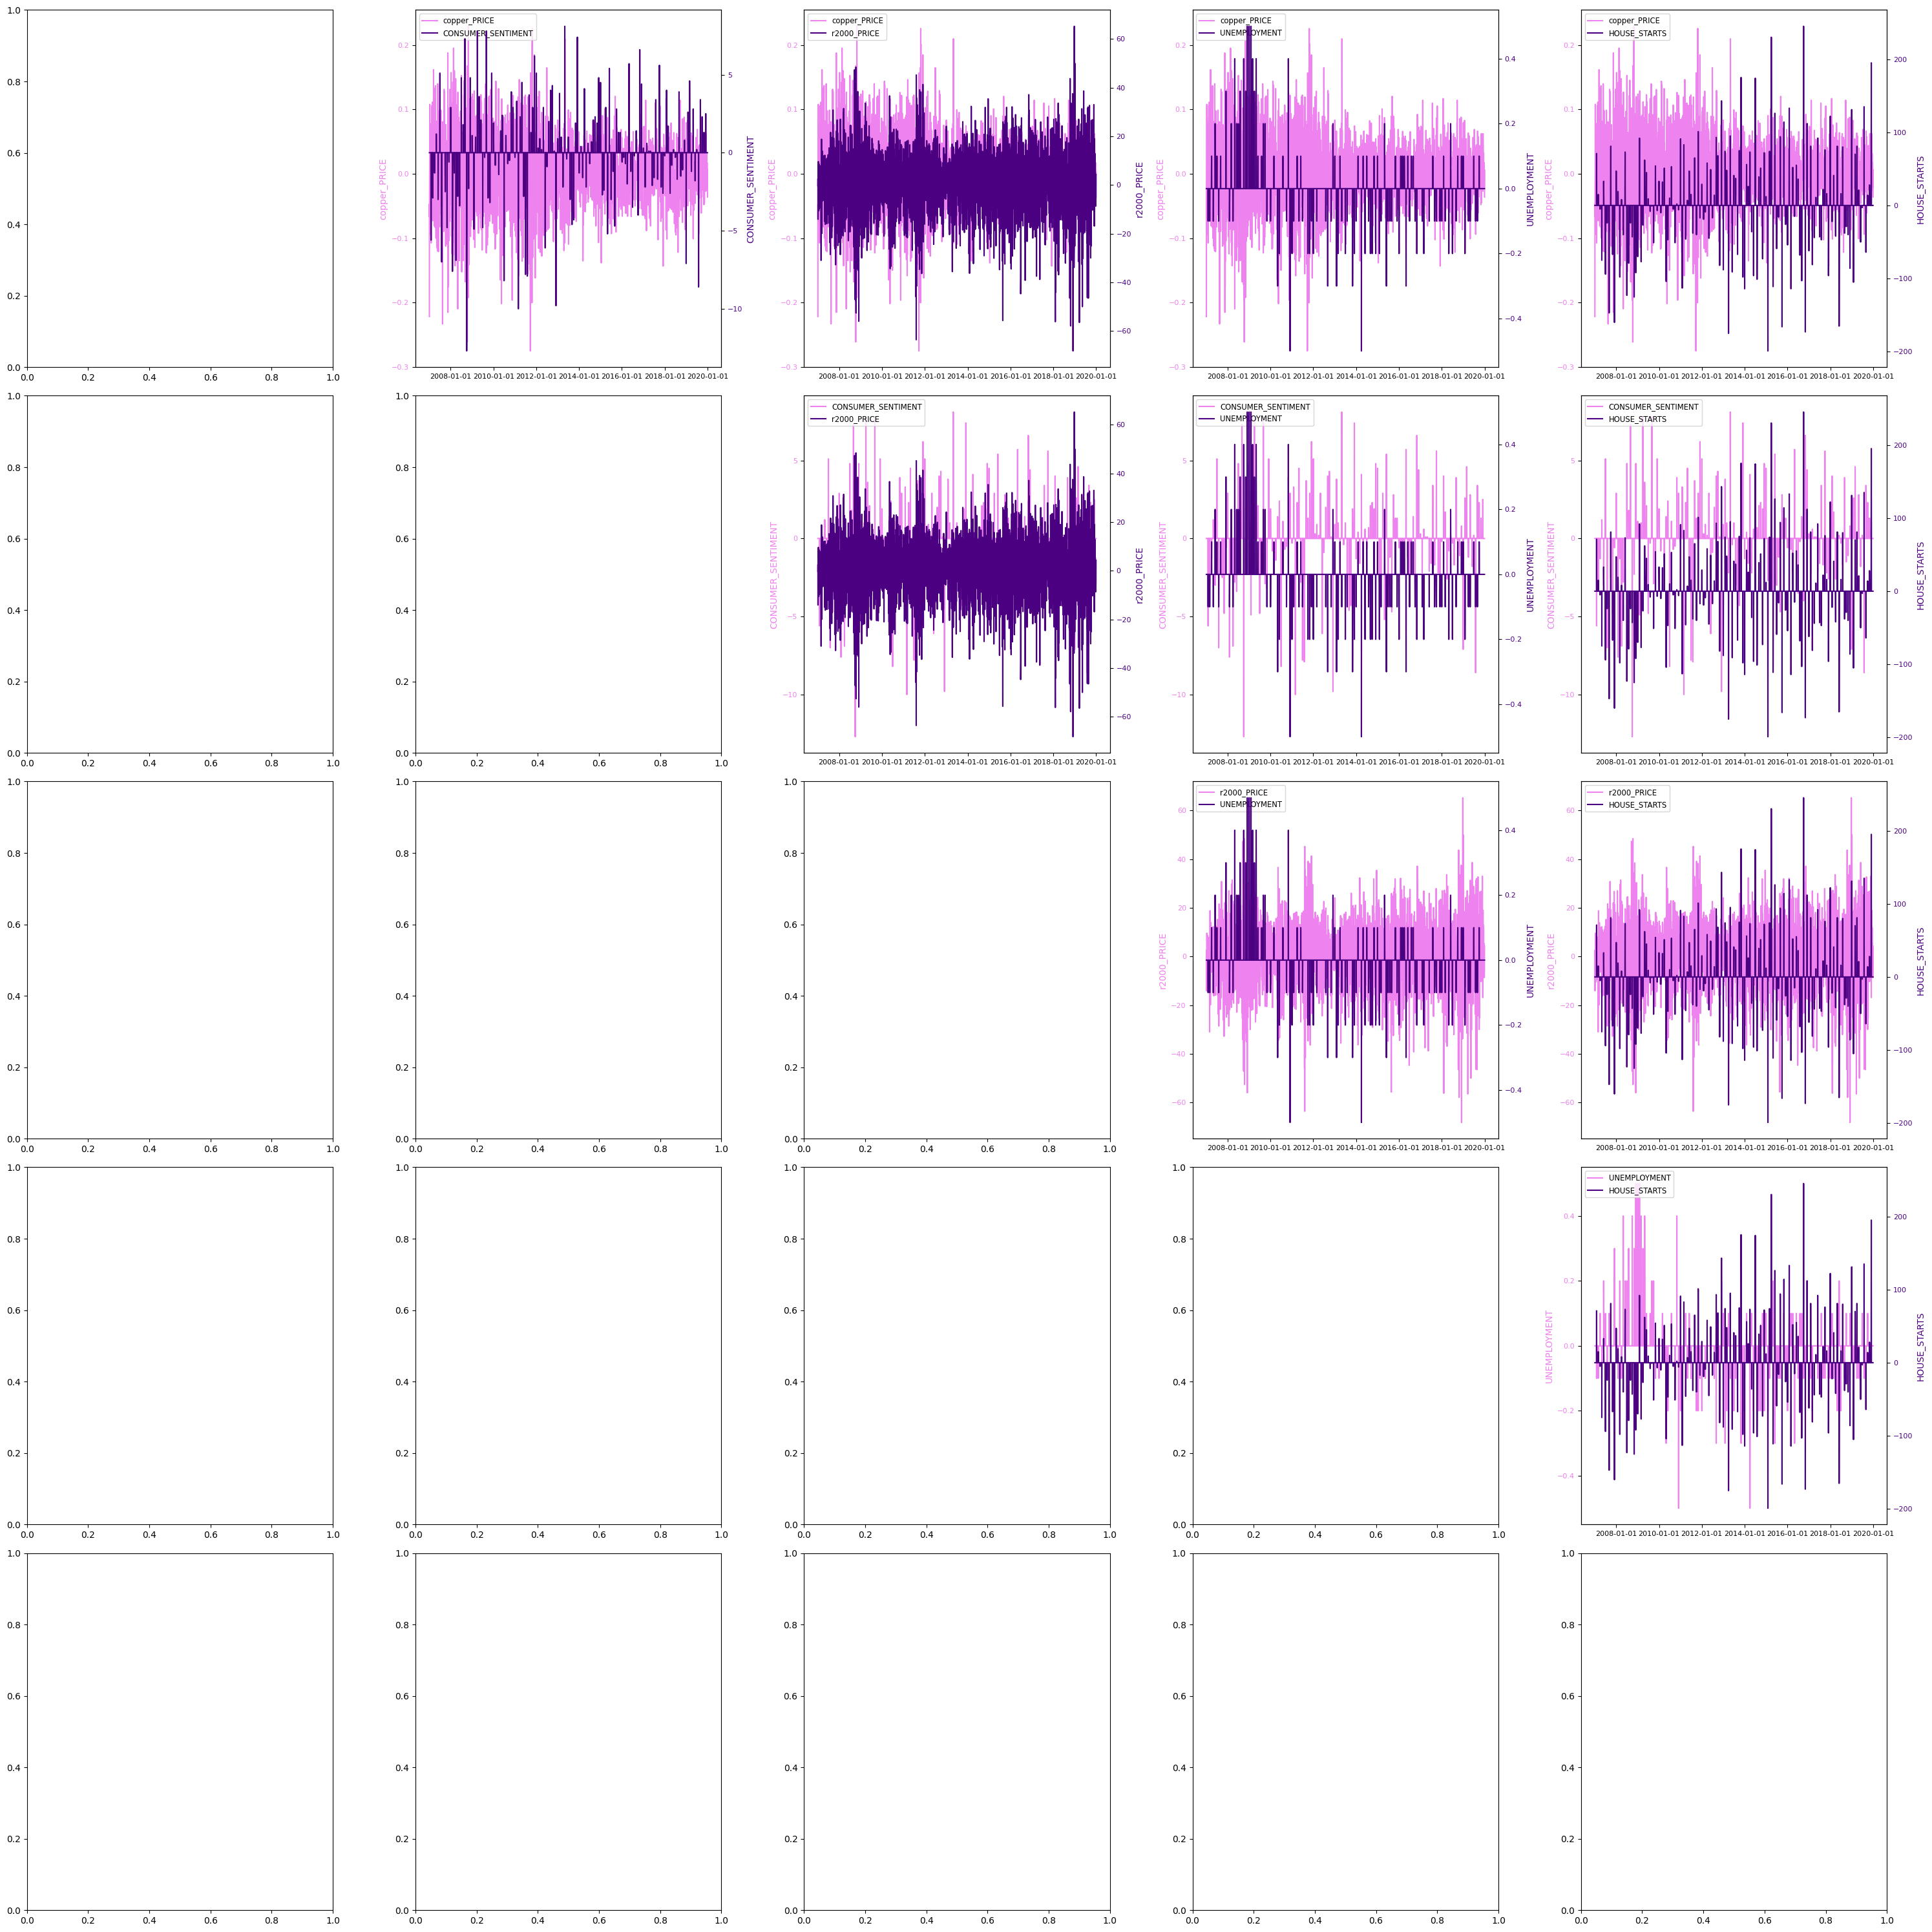

In [ ]:
# Take the first few differences to see how many iterations it'll take 
# to get to stationarity
diff1 = df
diff1[diff1.columns.drop('DATE')] = df[df.columns.drop('DATE')].diff().dropna()
fig, axes = vis.plot_pairwise_time_series_matrix(diff1)

Far fewwer concerns regarding stationarity at second differencing, but there are still some suspicious sections in some of these series.

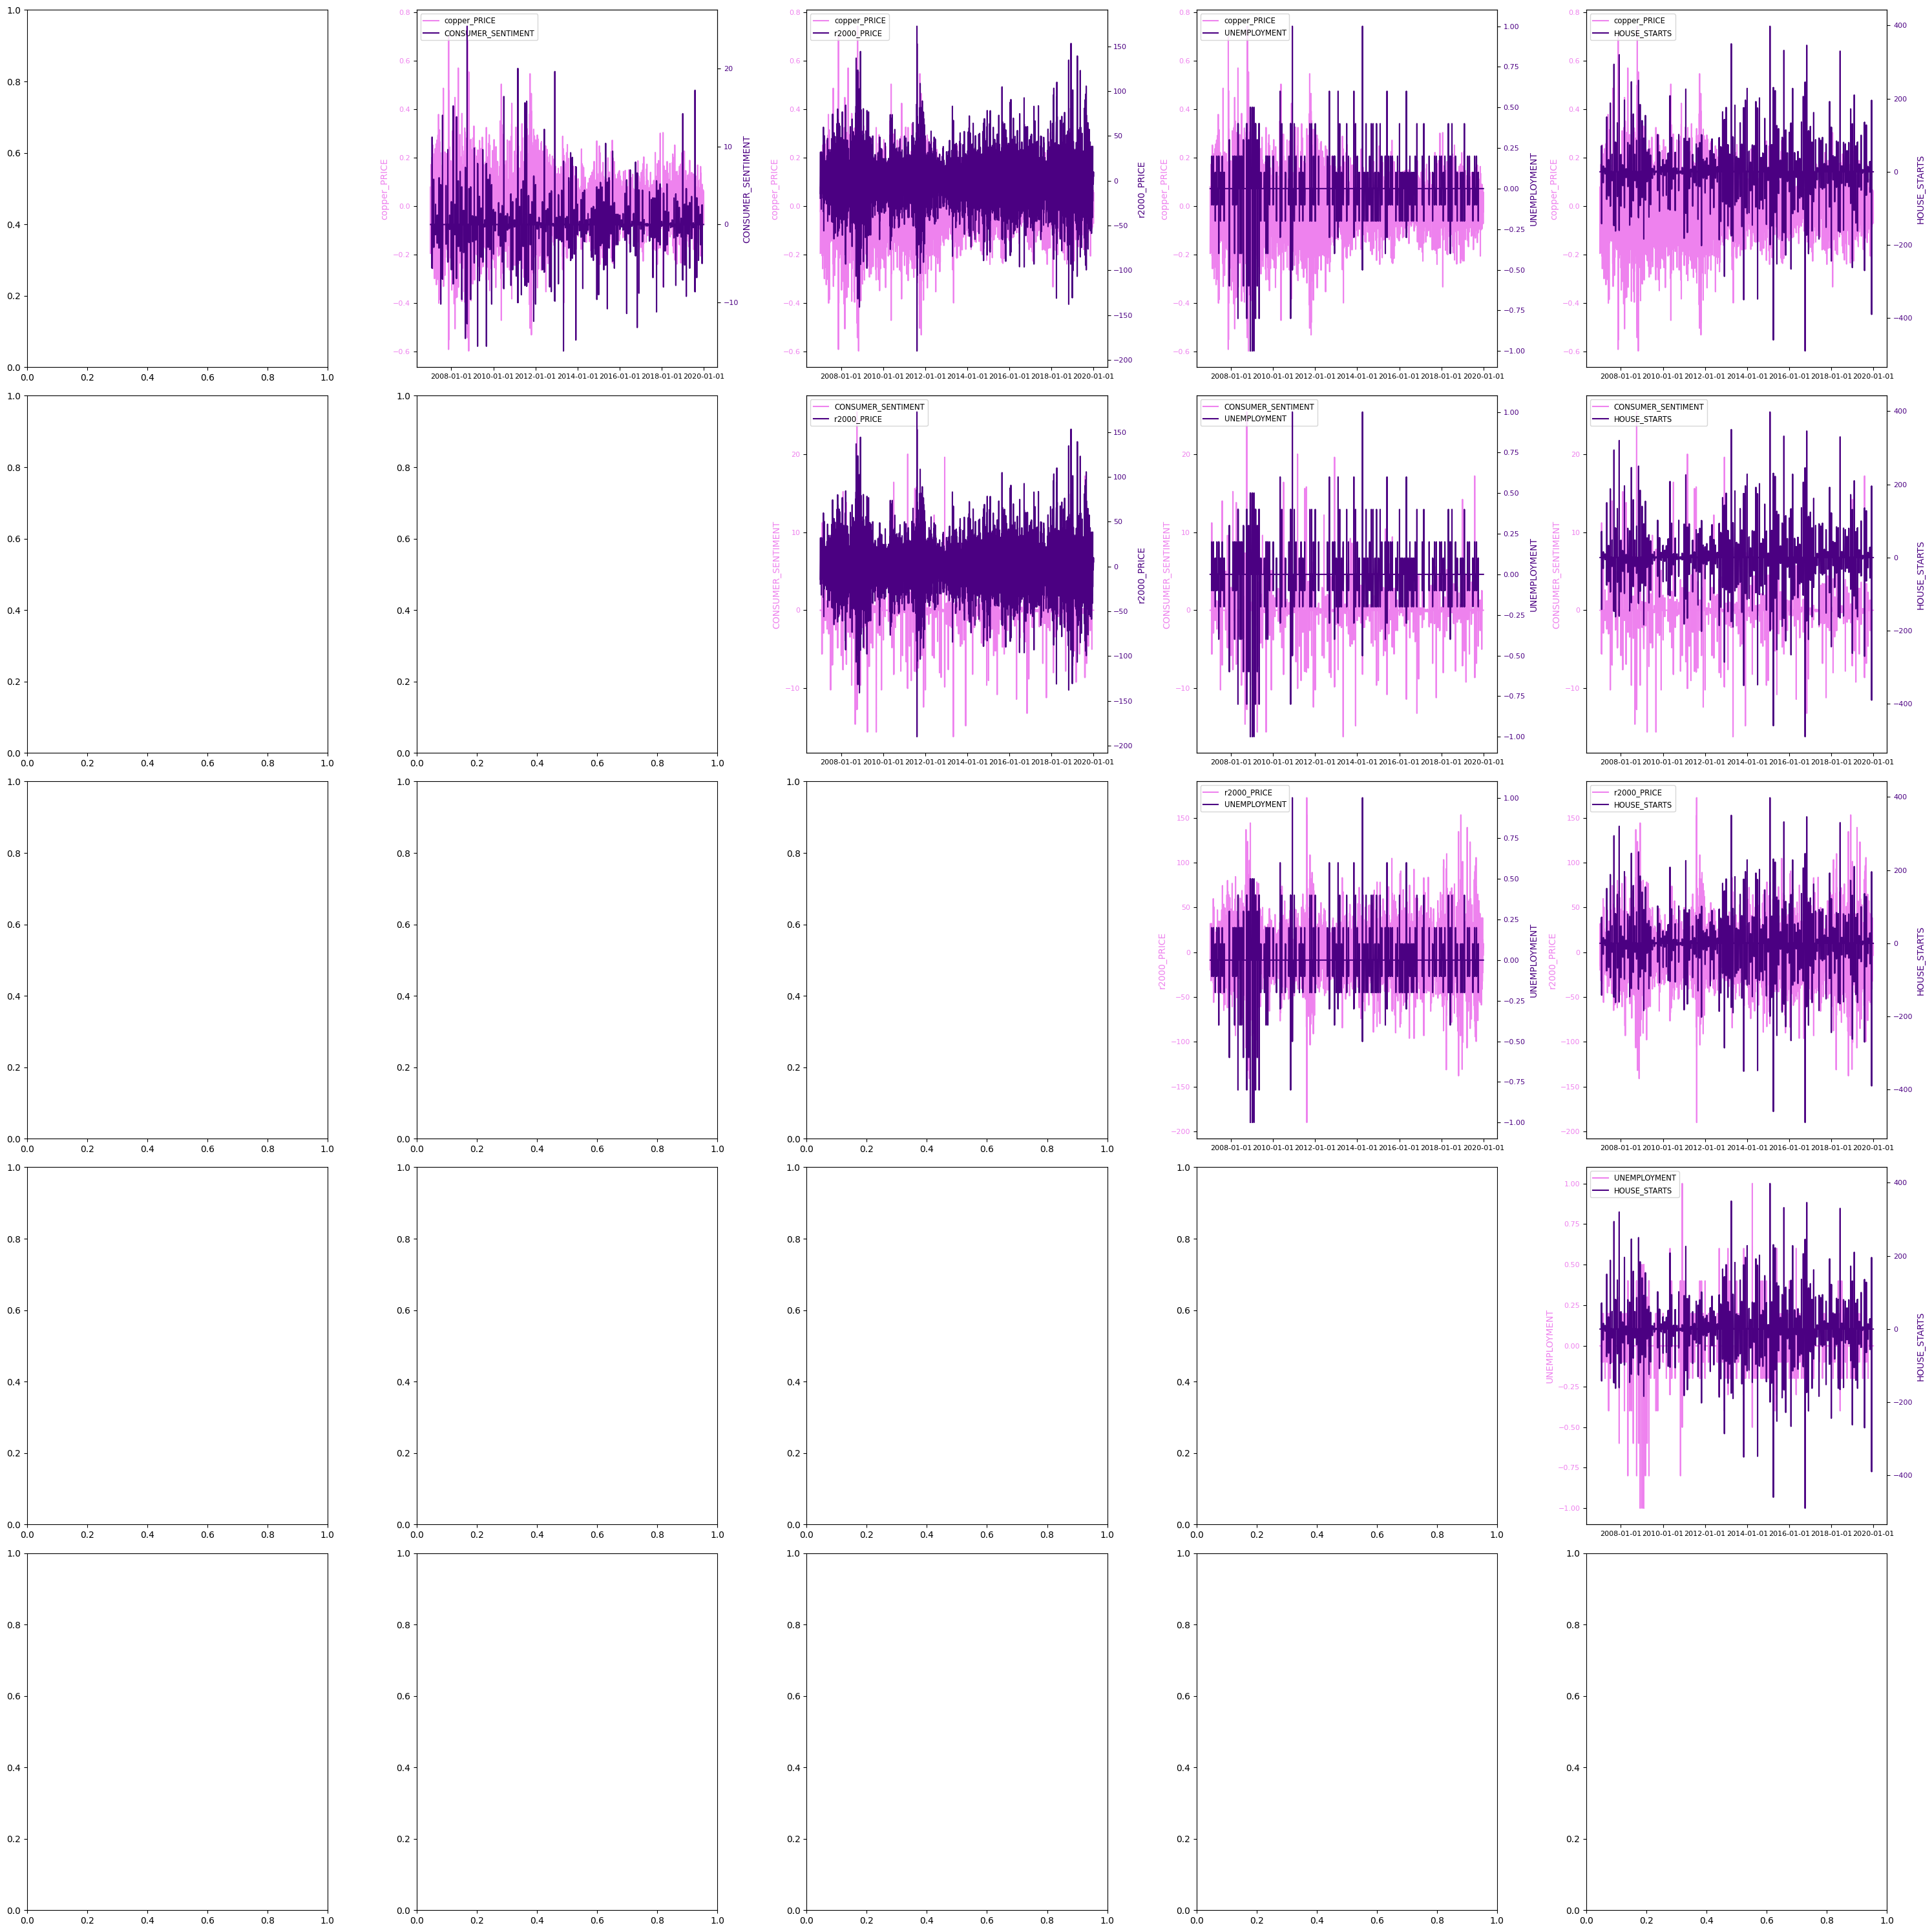

In [ ]:
diff2 = diff1
diff2[diff2.columns.drop('DATE')] = diff1[diff1.columns.drop('DATE')].diff().dropna()
fig, axes = vis.plot_pairwise_time_series_matrix(diff1)

### Baseline Models

In [ ]:
from skforecast import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax

In [ ]:
model = Sarimax(order = (1, 2, 1))

In [ ]:

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:150], train, c='blue')
plt.plot(x[150:], forecasts, c='green')
plt.show()

##### Training

In [ ]:
def prepare_multivariate_data(df, lags=3):
    """
    Prepare multivariate time series data for forecasting
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input time series DataFrame
    lags : int, optional (default=3)
        Number of lags to use for features
    
    Returns:
    --------
    X : numpy.ndarray
        Features matrix
    y : numpy.ndarray
        Target values
    """
    # Create lagged features for all series
    X = []
    y = []
    
    for col in df.columns:
        for i in range(len(df) - lags):
            # Create lag features
            lag_features = df.iloc[i:i+lags][col].values
            target = df.iloc[i+lags][col]
            
            X.append(lag_features)
            y.append(target)
    
    return np.array(X), np.array(y)

In [ ]:
def global_multivariate_forecast(df, forecast_horizon=5):
    """
    Perform global multi-series forecasting
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input time series DataFrame
    forecast_horizon : int, optional (default=5)
        Number of steps to forecast
    
    Returns:
    --------
    forecasts : pandas.DataFrame
        DataFrame with forecasts for each series
    """
    # Prepare data
    X, y = prepare_multivariate_data(df)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Initialize and train the forecaster
    forecaster = ForecasterAutoreg(
        regressor=LinearRegression(),
        lags=3,
        n_jobs='auto'
    )
    
    # Fit the global model
    forecaster.fit(X_train, y_train)
    
    # Forecast
    forecasts = {}
    for col in df.columns:
        # Forecast for each series
        series_forecast = forecaster.predict(forecast_horizon)
        forecasts[col] = series_forecast
    
    return pd.DataFrame(forecasts)


In [ ]:
import 

In [ ]:
#

##### Experiemental Models

In [ ]:
import pandas as pd
from piml import Experiment
from piml.models import XGB2Classifier